# Decision Tree & Random Forest for WU Data

## Import Packages

In [42]:
import numpy as np
import pandas as pd
import random
import datetime
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from prettytable import PrettyTable

# Ignore useless warnings 
import warnings
warnings.filterwarnings(action="ignore")    


In [43]:
import os
os.getcwd()

'/Users/danny/Desktop/MDS/master 4/CITS 5553 Data Science Capstone Project/Individual/Capstone-Individual/Data'

## Read Data

In [44]:
os.chdir('/Users/danny/Desktop/MDS/master 4/CITS 5553 Data Science Capstone Project/Individual/Capstone-Individual/Data')

In [45]:
df = pd.read_csv('aemo_wu_merged.csv', index_col = 0)
df.head()

,timestamp,Operational Demand (MW),temperature(celcius),dew_point(celcius),humidity(%),Wind,wind_speed(mph),wind_gush(mph),pressure(in),precip.(in),Condition
0,2017-01-22 00:00:00,1815.214,20.0,15.0,73.0,SSW,9.0,0.0,29.0,0.0,Fair
1,2017-01-22 00:30:00,1777.040,20.0,15.0,73.0,SSW,10.0,0.0,29.0,0.0,Fair
2,2017-01-22 01:00:00,1745.448,18.9,15.0,78.0,SSW,9.0,0.0,29.0,0.0,Fair
3,2017-01-22 01:30:00,1729.164,18.9,15.0,78.0,SSW,15.0,0.0,29.0,0.0,Fair
4,2017-01-22 02:00:00,1714.276,18.9,12.8,68.0,SSW,18.0,0.0,29.0,0.0,Fair


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97504 entries, 0 to 97503
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                97504 non-null  object 
 1   Operational Demand (MW)  97504 non-null  float64
 2   temperature(celcius)     97504 non-null  float64
 3   dew_point(celcius)       97504 non-null  float64
 4   humidity(%)              97504 non-null  float64
 5   Wind                     97504 non-null  object 
 6   wind_speed(mph)          97504 non-null  float64
 7   wind_gush(mph)           97504 non-null  float64
 8   pressure(in)             97504 non-null  float64
 9   precip.(in)              97504 non-null  float64
 10  Condition                97504 non-null  object 
dtypes: float64(8), object(3)
memory usage: 8.9+ MB


In [47]:
df.columns

Index(['timestamp', 'Operational Demand (MW)', 'temperature(celcius)',
       'dew_point(celcius)', 'humidity(%)', 'Wind', 'wind_speed(mph)',
       'wind_gush(mph)', 'pressure(in)', 'precip.(in)', 'Condition'],
      dtype='object')

## Data Preparation

In [48]:
# Seperate timestamp and set several new variables
def wind_ans(x):
    if x > 0: 
        return 1 
    else:
        return 0
# split time into date and interval timedf['Date'] = pd.to_datetime(df['Date'])
df[['Date','Trading Interval Time']] = df['timestamp'].str.split(" ",expand=True)
df['Date'] = pd.to_datetime(df['Date'])
df['new_timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['year'] = df['new_timestamp'].dt.year
df['month'] = df['new_timestamp'].dt.month
df['day'] = df['new_timestamp'].dt.day
df['hour'] = df['new_timestamp'].dt.hour
df['minute'] = df['new_timestamp'].dt.minute
df['Day_of_week'] = df['new_timestamp'].dt.dayofweek
df['Day_of_month'] = df['new_timestamp'].dt.day
df['Day_of_year'] = df['new_timestamp'].dt.dayofyear
df['has_Wind'] = df['wind_speed(mph)'].apply(wind_ans) 
df.set_index('timestamp', inplace=True, drop=True)
df.reset_index(inplace=True)
df.head()

,timestamp,Operational Demand (MW),temperature(celcius),dew_point(celcius),humidity(%),Wind,wind_speed(mph),wind_gush(mph),pressure(in),precip.(in),...,new_timestamp,year,month,day,hour,minute,Day_of_week,Day_of_month,Day_of_year,has_Wind
0,2017-01-22 00:00:00,1815.214,20.0,15.0,73.0,SSW,9.0,0.0,29.0,0.0,...,2017-01-22 00:00:00,2017,1,22,0,0,6,22,22,1
1,2017-01-22 00:30:00,1777.040,20.0,15.0,73.0,SSW,10.0,0.0,29.0,0.0,...,2017-01-22 00:30:00,2017,1,22,0,30,6,22,22,1
2,2017-01-22 01:00:00,1745.448,18.9,15.0,78.0,SSW,9.0,0.0,29.0,0.0,...,2017-01-22 01:00:00,2017,1,22,1,0,6,22,22,1
3,2017-01-22 01:30:00,1729.164,18.9,15.0,78.0,SSW,15.0,0.0,29.0,0.0,...,2017-01-22 01:30:00,2017,1,22,1,30,6,22,22,1
4,2017-01-22 02:00:00,1714.276,18.9,12.8,68.0,SSW,18.0,0.0,29.0,0.0,...,2017-01-22 02:00:00,2017,1,22,2,0,6,22,22,1


In [49]:
# def create_time_features(df_in):
#     df = df_in
#     df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
#     df['Year'] = df['timestamp'].dt.year
#     df['Month'] = df['timestamp'].dt.month
#     df['Hour'] = df['timestamp'].dt.hour
#     df['Day_of_week'] = df['timestamp'].dt.dayofweek
#     df['Day_of_month'] = df['timestamp'].dt.day
#     df['Day_of_year'] = df['timestamp'].dt.dayofyear
#     df.set_index('timestamp', inplace=True, drop=True)
#     # df = df.astype('int')
#     df.reset_index(inplace=True)
#     time_features_df = df
#     return time_features_df
# df_a = create_time_features(df)
# df_a.columns.tolist()
# df_a.head()

In [51]:
#select_col=['Operational Demand (MW)', 'temperature(celcius)', 'dew_point(celcius)', 'humidity(%)', 'wind_speed(mph)', 'year','Day_of_week','Day_of_month','Day_of_year']
df.index = df['Date']
select_col = ['Operational Demand (MW)', 'temperature(celcius)', 'dew_point(celcius)', 'humidity(%)', 'wind_speed(mph)', 'wind_gush(mph)', 'pressure(in)',
'Day_of_week', 'Day_of_month', 'Day_of_year','year','month','day','hour','minute']
y_col=['Operational Demand (MW)']
x_col=list(set(select_col)-set(y_col))
model_df=df[select_col]
training_dat = model_df[(model_df.index < '2020-12-01') | ('2021-04-01' < model_df.index)]
testing_dat = model_df[(model_df.index >= '2020-12-01') & ('2021-04-01' > model_df.index)]

X_train = training_dat.drop('Operational Demand (MW)',axis=1)
y_train = training_dat['Operational Demand (MW)']

X_test = testing_dat.drop('Operational Demand (MW)', axis = 1) 
y_test = testing_dat['Operational Demand (MW)']


## Function Preparation

In [52]:
def ModelScore(true,predict):
    print("Mean absolute error = ",round(sm.mean_absolute_error(true,predict),4))
    print("Mean squared error = ",round(sm.mean_squared_error(true,predict),4))
    print("Median absolute error = ",round(sm.median_absolute_error(true,predict),4))
    print("explained variance error = ",round(sm.explained_variance_score(true,predict),4))
    print("R2 error = ",round(sm.r2_score(true,predict),4))

def ImportanceDisplay(model):
    if 'grid' in model:
        impo_lst=[model,'.best_estimator_.feature_importances_']
    else:
        impo_lst=[model,'.feature_importances_']
    impo_str=''
    importance = eval(impo_str.join(impo_lst))
    #importance = rf_reg.feature_importances_
    table = PrettyTable(['Factors','Score'])
    for i,v in enumerate(importance):
	    table.add_row([x_col[i],round(v,4)])
    print(table)

## Feature Scale

In [53]:
# stdsc=StandardScaler()
# X_train_sc = stdsc.fit_transform(X_train)
# X_test_sc = stdsc.transform(X_test)

## Decision Tree

In [54]:
tree_reg = DecisionTreeRegressor(criterion='mse', random_state=42)

param_grid_dtree = dict(
    max_depth =[None,15,20,25],
    min_samples_leaf=[5,50,100])

grid_dtree=GridSearchCV(tree_reg, param_grid_dtree, cv=3, scoring='neg_root_mean_squared_error',verbose=2,return_train_score=True)

grid_dtree.fit(X_train,y_train)
y_pred_tree = grid_dtree.predict(X_test)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.3s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.3s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.3s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.2s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.2s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.2s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.2s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.2s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.2s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   0.3s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   0.3s
[CV] END ...................max_depth=15, min_sa

In [31]:
dtscore=ModelScore(y_test,y_pred_tree)
dtscore
ny_test=len(y_test)
mape = (sum(np.abs((y_test - y_pred_tree)/y_test))/ny_test)*100
print('Mape', mape)
ImportanceDisplay('grid_dtree')
print(grid_dtree.best_estimator_)
print(grid_dtree.best_score_)

Mean absolute error =  298.2482
Mean squared error =  150433.5621
Median absolute error =  229.1641
explained variance error =  0.3212
R2 error =  0.3212
training mape 14.652925266873373
+----------------------+--------+
|       Factors        | Score  |
+----------------------+--------+
|  dew_point(celcius)  | 0.329  |
|     pressure(in)     | 0.054  |
|    wind_gush(mph)    | 0.0795 |
|     Day_of_year      | 0.0264 |
|     humidity(%)      |  0.0   |
|     Day_of_month     | 0.0153 |
|   wind_speed(mph)    | 0.0969 |
|     Day_of_week      | 0.0197 |
|        month         | 0.3181 |
| temperature(celcius) | 0.0494 |
|         year         | 0.001  |
|         day          | 0.0107 |
+----------------------+--------+
DecisionTreeRegressor(criterion='mse', max_depth=15, min_samples_leaf=100,
                      random_state=42)
-348.48859615957946


In [ ]:
fig = plt.figure(figsize=(16,12))
a_rf_smote = plot_tree(grid_dtree.best_estimator_, feature_names=X_train.columns, fontsize=12, filled=True, class_names=['0', '1'])

In [32]:
y_pred_tree = pd.DataFrame(y_pred_tree)
predict_table_tree = pd.DataFrame(y_test)
predict_table_tree.insert(1,'predict',y_pred_tree)
predict_table_tree

,Operational Demand (MW),predict
Date,,
2020-12-01,1750.880,1823.788000
2020-12-01,1709.428,1823.788000
2020-12-01,1708.242,1823.788000
2020-12-01,1692.028,1823.788000
2020-12-01,1677.540,1823.788000
...,...,...
2021-03-31,2215.146,2147.547500
2021-03-31,2147.296,2147.547500
2021-03-31,2072.562,2147.547500


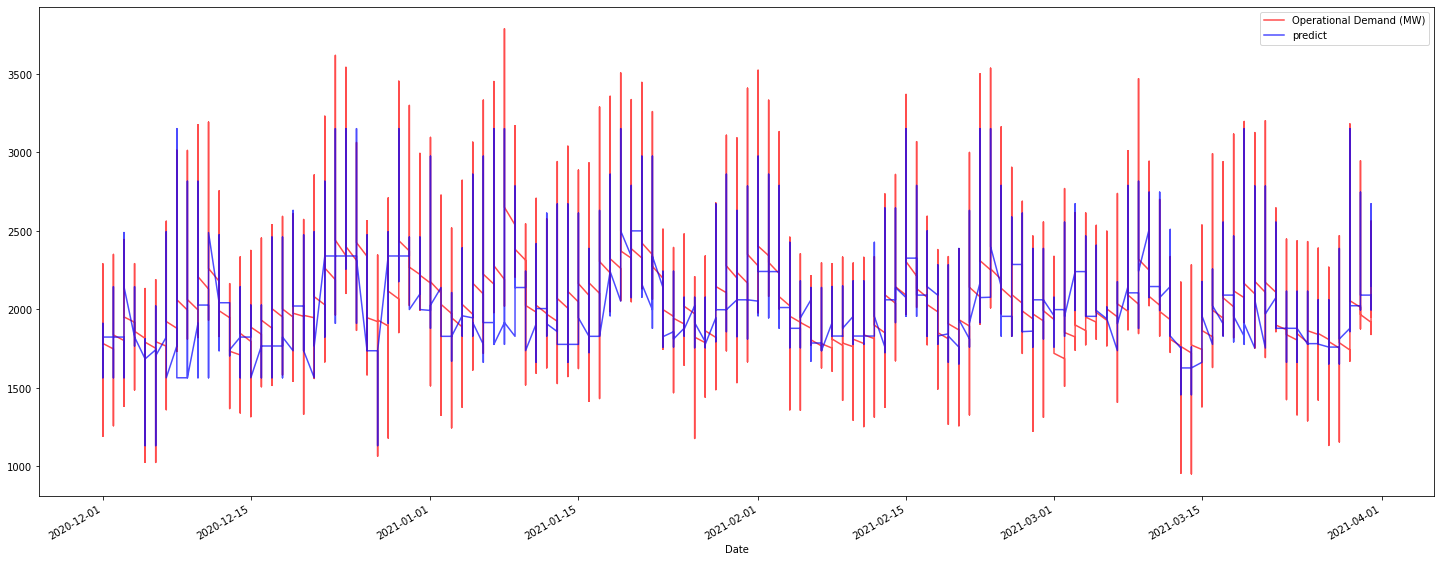

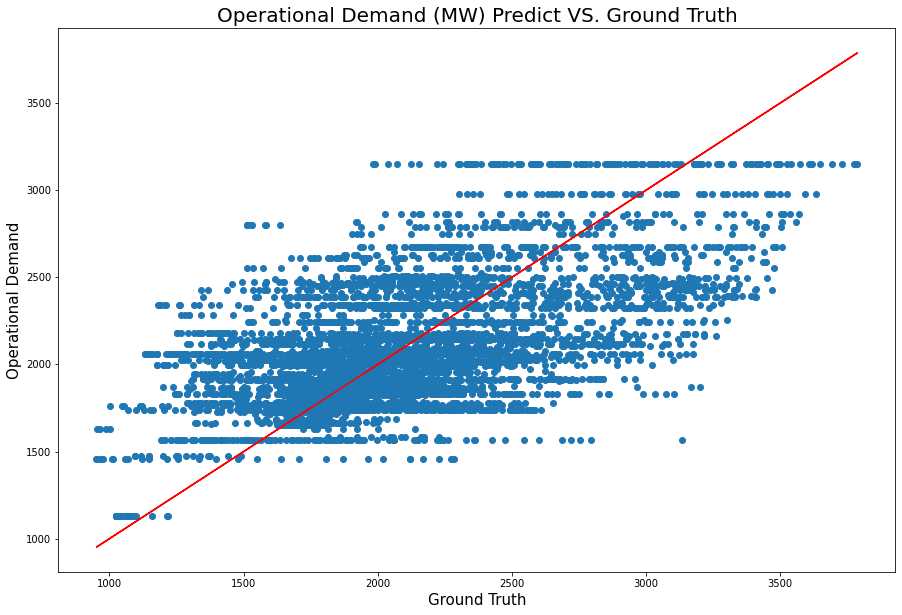

In [33]:
predict_table_tree.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table_tree['Operational Demand (MW)'], predict_table_tree['predict'])
plt.plot(predict_table_tree['Operational Demand (MW)'],predict_table_tree['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

## Random Forest

In [34]:
forest = RandomForestRegressor(criterion='mse', random_state=42)

param_grid_forest = dict(
    max_depth =[None,15,20,25],
    min_samples_leaf=[5,50,100])

grid_forest=GridSearchCV(forest, param_grid_forest, cv=3, scoring='neg_root_mean_squared_error',verbose=2,return_train_score=True)

grid_forest.fit(X_train,y_train)
y_predict_forest = grid_forest.predict(X_test)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  14.3s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  14.3s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  15.4s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=  10.3s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=  10.4s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=  11.3s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   9.3s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   9.4s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=  10.0s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=  12.5s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=  12.4s
[CV] END ...................max_depth=15, min_sa

In [35]:
ny_test = len(y_test)
mape = (sum(np.abs((y_test - y_predict_forest)/y_test))/ny_test)*100
print('training mape', mape)
rfscore=ModelScore(y_test,y_predict_forest)
rfscore
ImportanceDisplay('grid_forest')
print(grid_forest.best_estimator_)
print(grid_forest.best_score_)

training mape 14.119097854611859
Mean absolute error =  285.5788
Mean squared error =  139186.5936
Median absolute error =  216.8775
explained variance error =  0.372
R2 error =  0.3719
+----------------------+--------+
|       Factors        | Score  |
+----------------------+--------+
|  dew_point(celcius)  | 0.3149 |
|     pressure(in)     | 0.0571 |
|    wind_gush(mph)    | 0.0797 |
|     Day_of_year      | 0.0316 |
|     humidity(%)      |  0.0   |
|     Day_of_month     | 0.0136 |
|   wind_speed(mph)    | 0.0957 |
|     Day_of_week      | 0.0201 |
|        month         | 0.304  |
| temperature(celcius) | 0.0567 |
|         year         | 0.0063 |
|         day          | 0.0202 |
+----------------------+--------+
RandomForestRegressor(criterion='mse', max_depth=15, min_samples_leaf=50,
                      random_state=42)
-335.719382966292


In [36]:
y_predict_forest = pd.DataFrame(y_predict_forest)
predict_table = pd.DataFrame(y_test)
predict_table.insert(1,'predict',y_predict_forest)
predict_table

,Operational Demand (MW),predict
Date,,
2020-12-01,1750.880,1749.888320
2020-12-01,1709.428,1748.062584
2020-12-01,1708.242,1746.554641
2020-12-01,1692.028,1748.062584
2020-12-01,1677.540,1742.152808
...,...,...
2021-03-31,2215.146,2190.769256
2021-03-31,2147.296,2175.105889
2021-03-31,2072.562,2209.848401


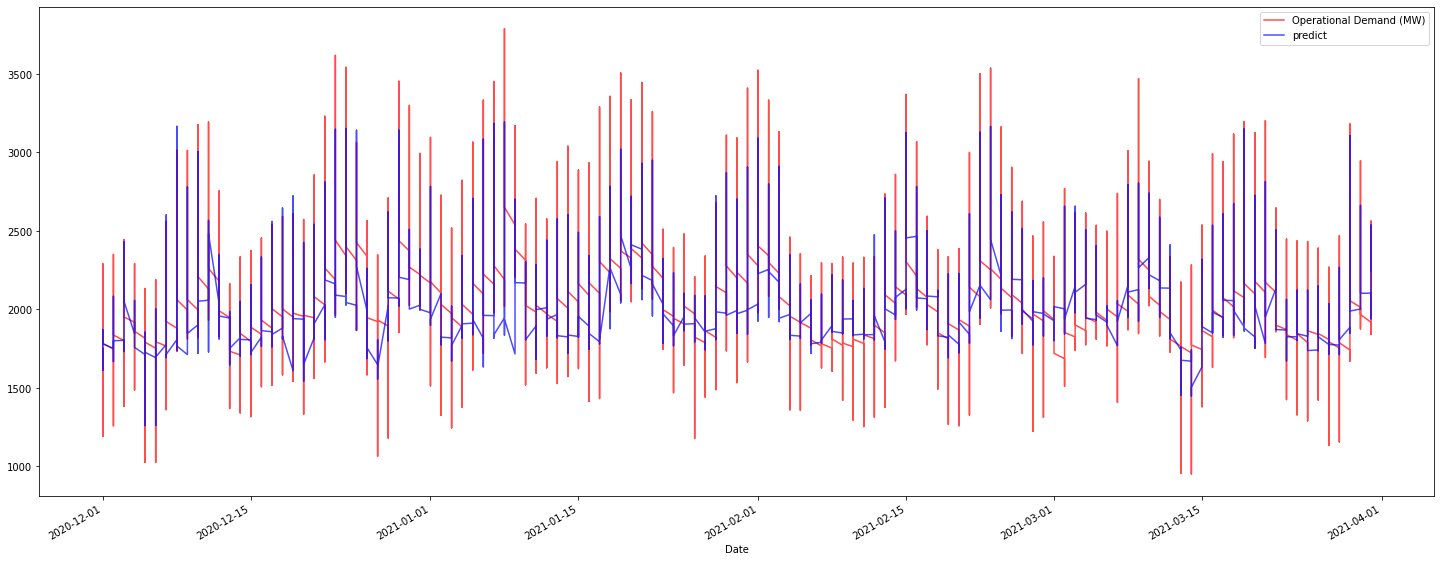

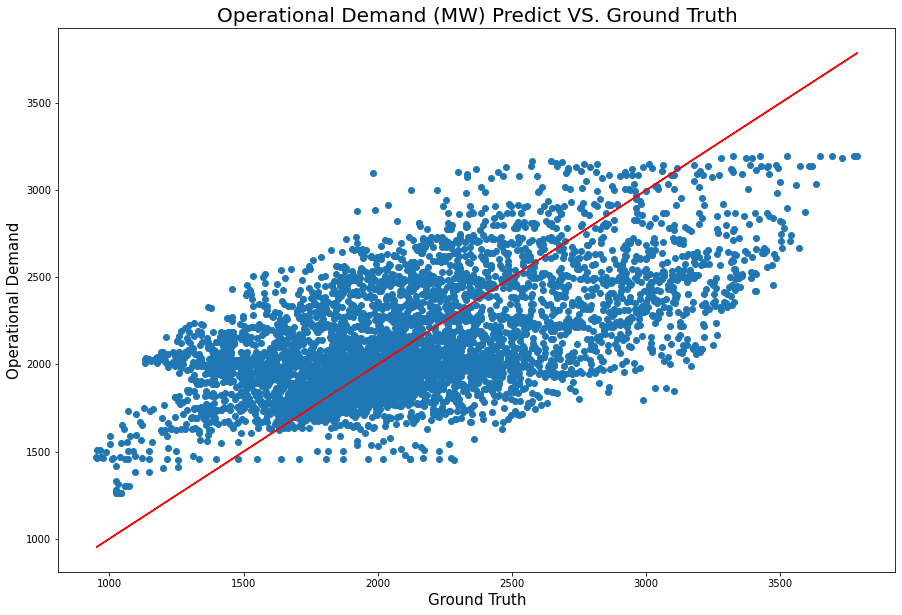

In [37]:
predict_table.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table['Operational Demand (MW)'], predict_table['predict'])
plt.plot(predict_table['Operational Demand (MW)'],predict_table['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()